In [251]:
%matplotlib inline
import numpy as np
import pypico
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

In [252]:
# Note i didn't upload the data file to github as it's too large
# comment my path and change to your own path to see data

# pico data on pypico's github
pico = pypico.load_pico("../data/jcset_py3.dat")
# FROM: http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')

/var/folders/_2/d0xmq0nn39z8s3ccvbbr049h0000gn/T/ipykernel_69938/2570485871.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')


In [253]:
# example parameters from pypico
As = 2.08e-9
ns = 0.97
tau = 0.055
ombh2 = 0.0225
omch2 = 0.117
H0 = 50
omk = -0.05
pivot_scalar = 0.05


In [254]:
df

l           Dl        -dDl         +dDl
0        2.0   225.895000  132.369000   533.062000
1        3.0   936.920000  450.471000  1212.308000
2        4.0   692.238000  294.111000   666.469000
3        5.0  1501.705000  574.432000  1155.804000
4        6.0   557.611000  201.242000   375.763000
...      ...          ...         ...          ...
2502  2504.0   212.915616  110.537143   110.537143
2503  2505.0    54.752355  110.824874   110.824874
2504  2506.0  -149.315007  111.110198   111.110198
2505  2507.0   -71.474213  111.427400   111.427400
2506  2508.0    51.632731  111.716422   111.716422

[2507 rows x 4 columns]

note that
\begin{equation}
D_l = C_{l}\frac{l(l + 1)}{2\pi}
\end{equation}

In [255]:
def model(As, ns, tau, ombh2, omch2, H0, omk, pico=pico):
    '''
    to generate the model datas with pico

    Parameters
    ----------
    As, ns, tau, ombh2, omch2, H0, omk: parameters of model
    pico: pico object, to choose your model

    Returns
    ----------
    power spectrum
    '''
    #load our input dire
    input_dir = {'As': As,
                'ns': ns,
                'tau': tau,
                'ombh2': ombh2,
                'omch2': omch2,
                'H0': H0,
                'omk': omk}

    result = pico.get(**input_dir, force=True)      # set True as we will use MCMC
    dl_TT = result['dl_TT']

    # TODO: the pico.outputs() gives ['cl_TT']; the result above gives ['dl_TT']
    # do i have to transfer as above?
    #cl_TT = [dl_TT[i]*2*np.pi/(i*(i+1)) for i in range(len(dl_TT))]

    return dl_TT


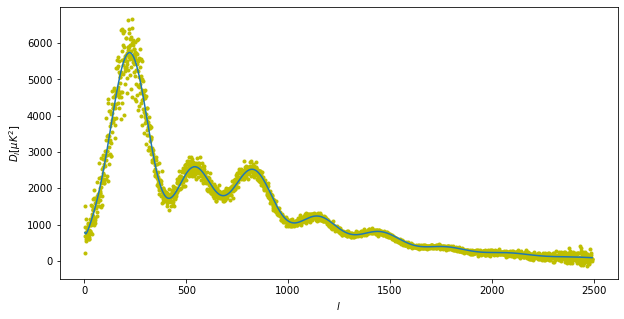

In [256]:
# just plot the example data to make sure we are on the right track
dl = model(As, ns, tau, ombh2, omch2, H0, omk)
dl = dl[2:]

plt.figure(figsize=(10, 5))
#plt.errorbar(df['l'][:len(dl)], df['Dl'][:len(dl)], yerr=df['+dDl'][:len(dl)], fmt=".y", capsize=0)
plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.plot(df['l'][:len(dl)], dl)
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")
plt.show()

In [257]:
# helper function for MCMC

def log_prior(theta):
    As, ns, tau, ombh2, omch2, H0, omk = theta
    if (20 < H0 < 100 and .005 < ombh2 < .1 and .001 < omch2 < .99 and .01 < tau < .2 and .8 < ns < 1.2 and 1e-10 < As < 9e-9 and -0.1 < omk < -0.01):
        return 0
    return -np.inf


def log_likeli(theta, df=df):
    #load data
    As, ns, tau, ombh2, omch2, H0, omk = theta
    dmodel = model(As, ns, tau, ombh2, omch2, H0, omk)
    data = df.copy()
    # keep l of model and data the same
    dmodel = dmodel[2:]
    data = data[:len(dmodel)]

    data['err'] = (data['+dDl'] + data['-dDl']) / 2
    data['err2'] = data['err']**2

    return -0.5 * np.sum(((data['Dl'] - dmodel)/data['err2']) ** 2  + np.log(data['err2'])*2*np.pi)


def log_post(theta, df=df):
    data = df.copy()
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likeli(theta, df=df)

In [258]:
# set MCMC
nwalkers = 30
ndim = 7

num_iter = 5000

pos = 0.01*np.random.rand(nwalkers, ndim)+.995
pos[:, 0] *= As
pos[:, 1] *= ns
pos[:, 2] *= tau
pos[:, 3] *= ombh2
pos[:, 4] *= omch2
pos[:, 5] *= H0
pos[:, 6] *= omk

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
sampler.run_mcmc(pos, num_iter, progress=True)

100%|██████████| 5000/5000 [06:19<00:00, 13.18it/s]


State([[ 2.90859366e-09  8.55806757e-01  1.80510299e-01  2.56273792e-02
   1.00421031e-01  6.31088494e+01 -3.25962554e-02]
 [ 1.74774433e-09  1.14412173e+00  7.64445866e-02  3.44817275e-02
   6.93700255e-02  7.34673774e+01 -2.28336357e-02]
 [ 2.56123927e-09  9.84589863e-01  1.36545525e-01  2.24127331e-02
   1.39073741e-01  4.81037385e+01 -6.97869880e-02]
 [ 1.87701620e-09  1.02165300e+00  2.95992797e-02  1.67039579e-02
   7.03881786e-02  4.56972878e+01 -9.06163331e-02]
 [ 1.85168519e-09  1.17798852e+00  6.74466818e-02  3.52449097e-02
   1.03180962e-01  6.44880325e+01 -5.68521501e-02]
 [ 2.28094587e-09  1.00709318e+00  6.42648246e-02  1.69472355e-02
   2.27749792e-01  3.25221684e+01 -2.10813309e-02]
 [ 2.09925701e-09  1.01373807e+00  8.25231368e-02  3.44184033e-02
   6.85025609e-02  6.63718756e+01 -5.08828812e-02]
 [ 2.39542261e-09  9.65577134e-01  8.21772257e-02  2.10709934e-02
   7.65334614e-02  6.02777798e+01 -4.56827643e-02]
 [ 1.98919461e-09  8.46694936e-01  6.88616128e-02  2.46719

In [259]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

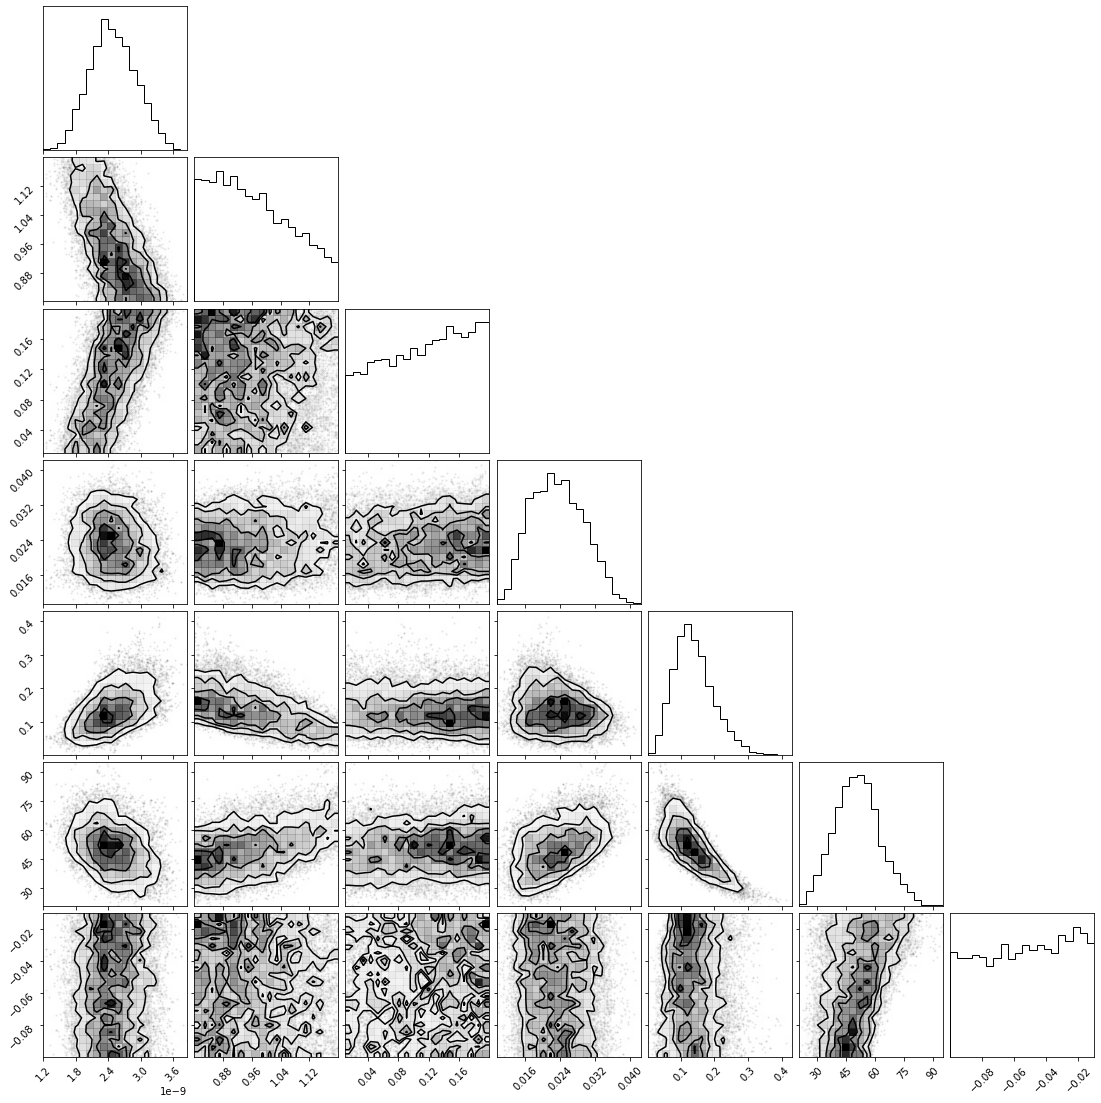

In [260]:
fig = corner.corner(flat_samples)

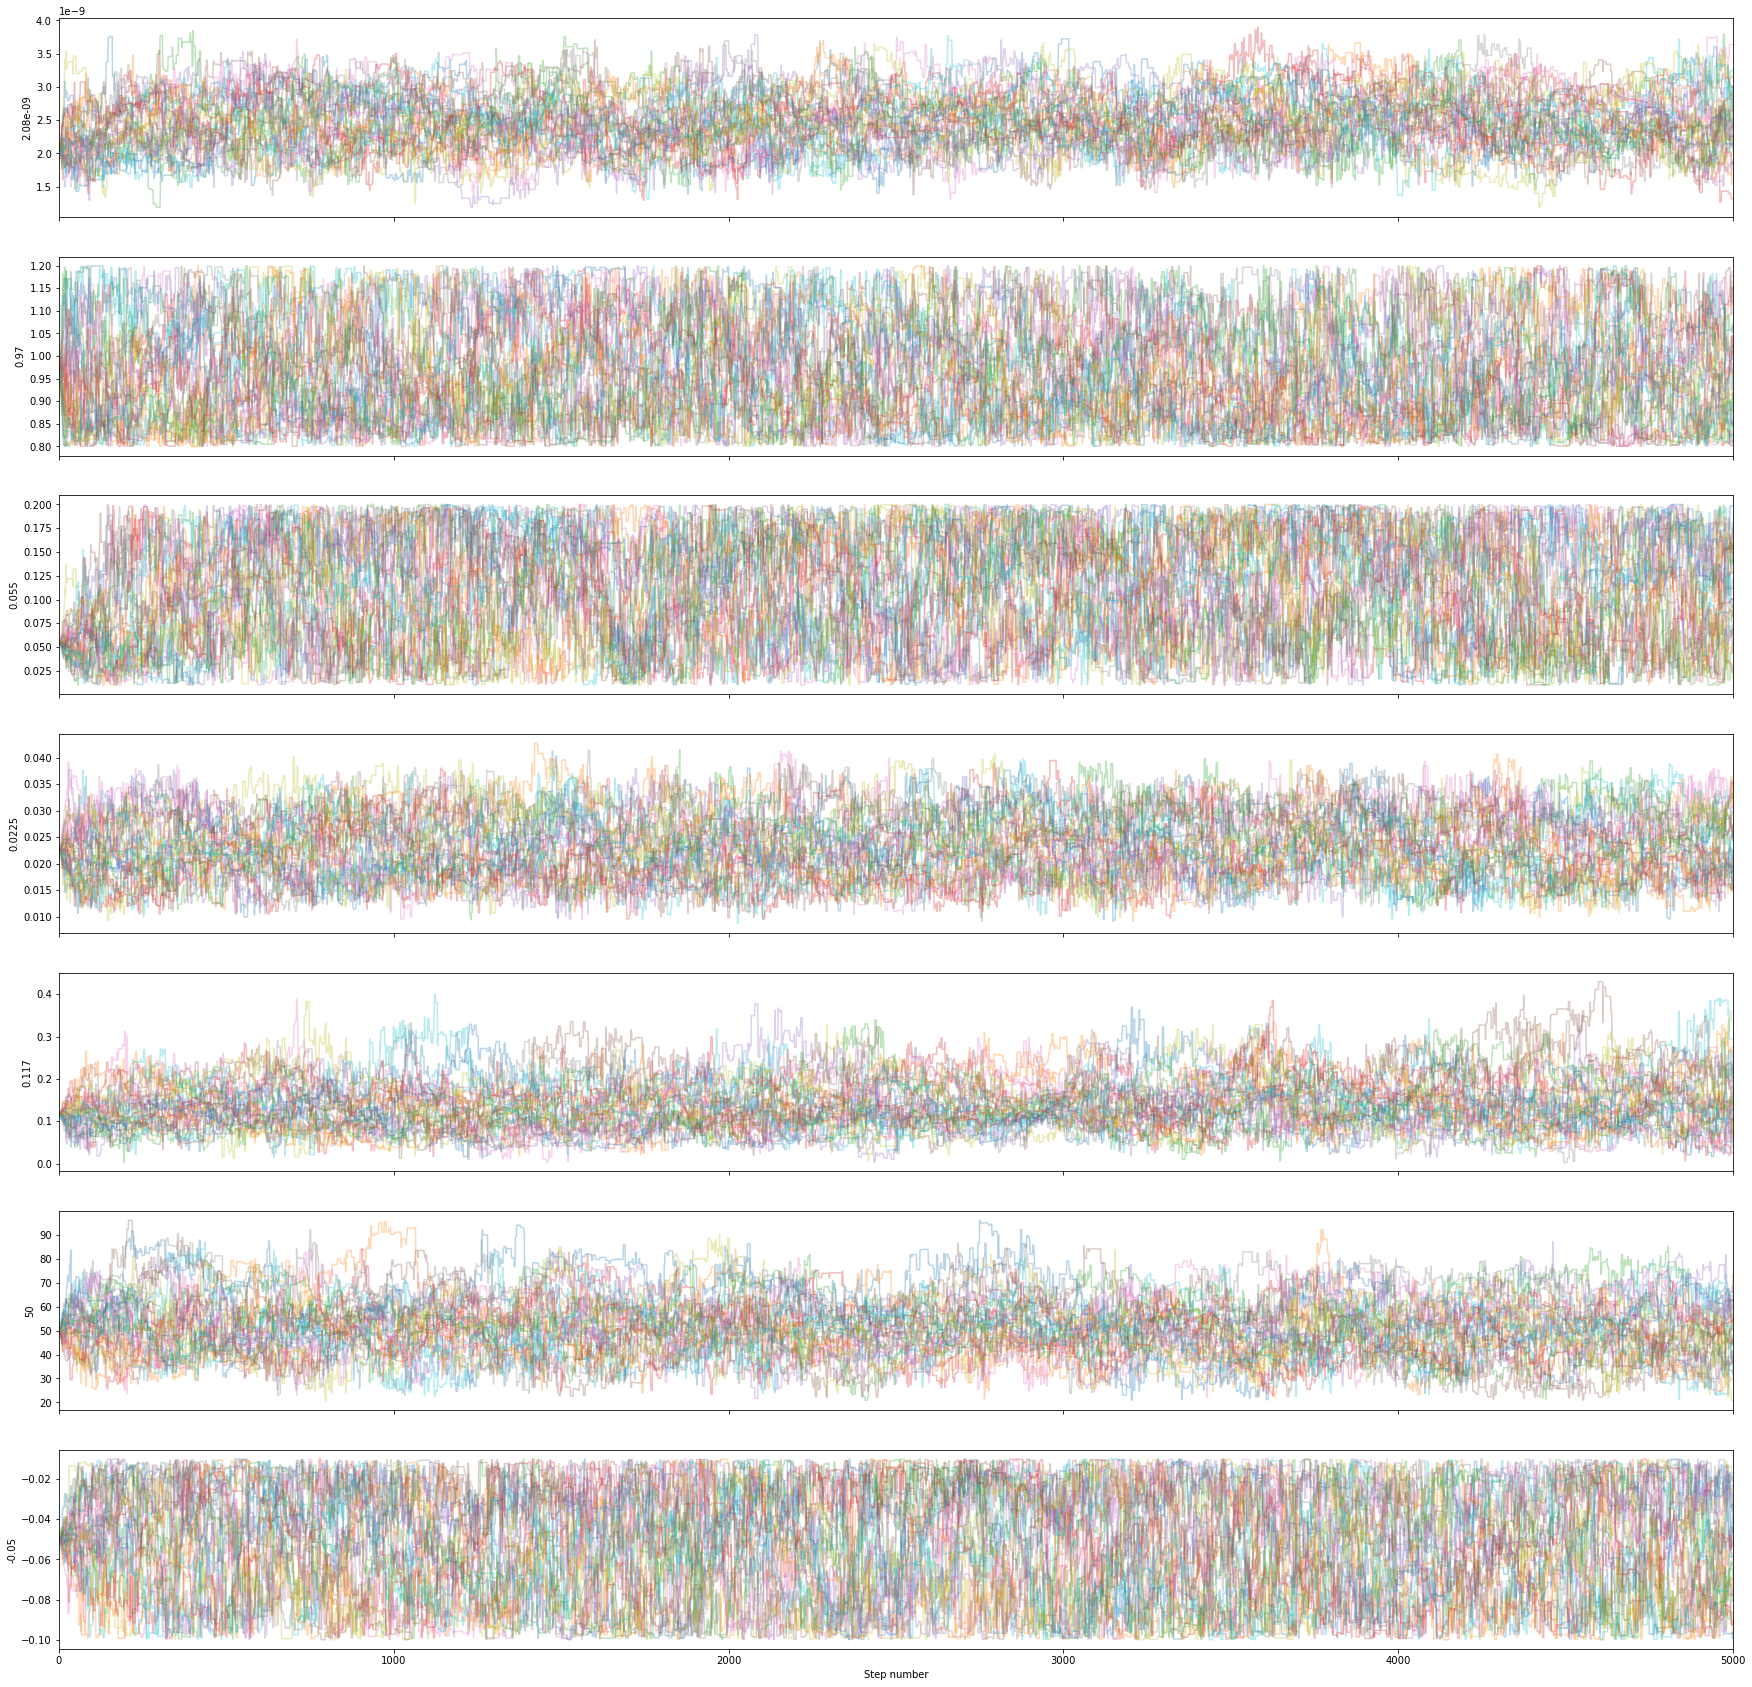

In [261]:
f, axes = plt.subplots(ndim, figsize=(30, 30), sharex=True)
samples = sampler.get_chain()
labels = [As, ns, tau, ombh2, omch2, H0, omk]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

Text(0, 0.5, '$D_{l} [\\mu K^2]$')

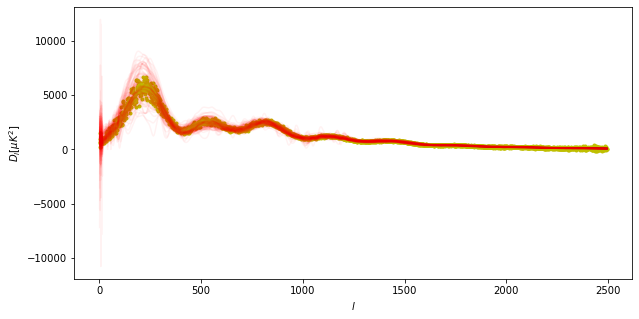

In [262]:
inds = np.random.randint(len(flat_samples), size=100)
x = df['l'][:len(dl)]

plt.figure(figsize=(10, 5))
for ind in inds:
    s = flat_samples[ind]
    As_s, ns_s, tau_s, ombh2_s, omch2_s, H0_s, omk_s = s
    dl_s = model(As_s, ns_s, tau_s, ombh2_s, omch2_s, H0_s, omk_s)[2:]
    plt.plot(x, dl_s, alpha=0.05, color='red')
#plt.errorbar(df['l'][:len(dl)], df['Dl'][:len(dl)], yerr=df['+dDl'][:len(dl)], fmt=".y", capsize=0)
plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")

In [263]:
mean_param = np.mean(np.mean(samples, axis=0), axis=0)
# mean_param = np.mean(flat_samples, axis=0)
mean_param

array([ 2.47275206e-09,  9.63625247e-01,  1.10452461e-01,  2.33340854e-02,
        1.38303180e-01,  5.13318676e+01, -5.28248234e-02])

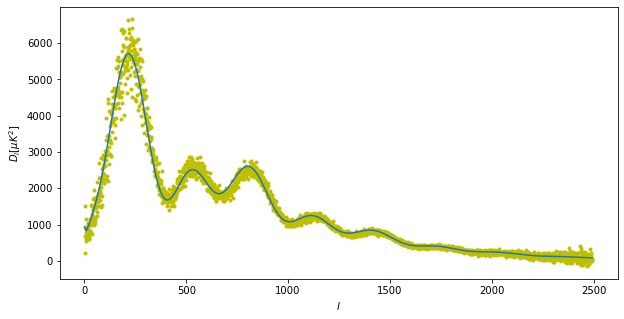

In [264]:
As_m, ns_m, tau_m, ombh2_m, omch2_m, H0_m, omk_m = mean_param
dl = model(As_m, ns_m, tau_m, ombh2_m, omch2_m, H0_m, omk_m)
dl = dl[2:]

plt.figure(figsize=(10, 5))
#plt.errorbar(df['l'][:len(dl)], df['Dl'][:len(dl)], yerr=df['+dDl'][:len(dl)], fmt=".y", capsize=0)
plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.plot(df['l'][:len(dl)], dl)
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")
plt.show()